# 4. Calculate variance of Stokes and anti-Stokes measurements

In [1]:
import os

from dtscalibration import read_silixa_files
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
try:
    wd = os.path.dirname(os.path.realpath(__file__))
except:
    wd = os.getcwd()

filepath = os.path.join(wd, '..', '..', 'tests', 'data', 'double_ended2')
timezone_netcdf = 'UTC',
timezone_ultima_xml = 'Europe/Amsterdam'
file_ext = '*.xml'

ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf=timezone_netcdf,
    timezone_ultima_xml=timezone_ultima_xml,
    file_ext=file_ext)
sections = {
    'probe1Temperature': [slice(7.5, 17.), slice(70., 80.)],  # cold bath
    'probe2Temperature': [slice(24., 34.), slice(85., 95.)],  # warm bath
    }

6 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 1693 points along the cable
The measurement is double ended


In [3]:
print(ds.variance_stokes.__doc__)


        Calculates the variance between the measurements and a best fit exponential at each
        reference section. This fits a two-parameter exponential to the stokes measurements. The
        temperature is constant and there are no splices/sharp bends in each reference section.
        Therefore all signal decrease is due to differential attenuation, which is the same for
        each reference section. The scale of the exponential does differ per reference section.

        Assumptions: 1) the temperature is the same along a reference section. 2) no sharp bends
        and splices in the reference sections. 3) Same type of optical cable in each reference
        section.

        Idea from discussion at page 127 in Richter, P. H. (1995). Estimating errors in
        least-squares fitting. For weights used error propagation:
        w^2 = 1/sigma(lny)^2 = y^2/sigma(y)^2 = y^2

        Parameters
        ----------
        use_statsmodels
        suppress_info
        st_label : 

In [4]:
I_var, residuals = ds.variance_stokes(st_label='ST', 
                                      sections=sections, 
                                      use_statsmodels=False)
print("The variance of the Stokes signal along the reference sections "
      "is approximately {} on a {} sec acquisition time".format(I_var, ds.userAcquisitionTimeFW.data[0]))

The variance of the Stokes signal along the reference sections is approximately 12.021050418534966 on a 2.0 sec acquisition time


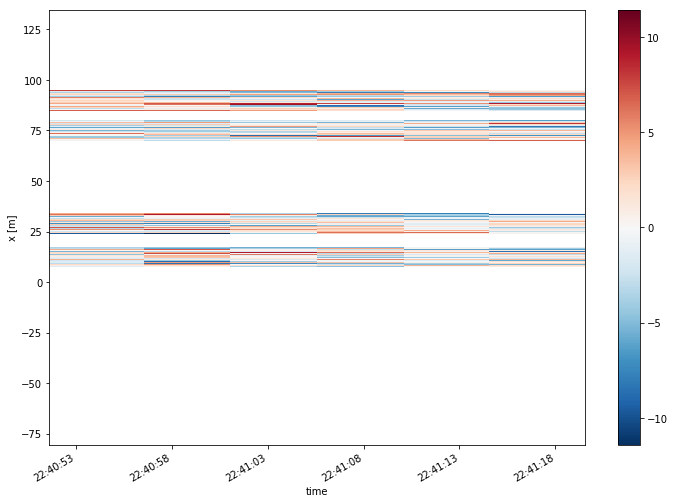

In [5]:
residuals.plot(figsize=(12, 8));

The residuals should be normally distributed and independent from previous time steps and other points along the cable. If you observe patterns in the residuals plot (above), it might be caused by:
- The temperature in the calibration bath is not uniform
- Attenuation caused by coils/sharp bends in cable
- Attenuation caused by a splice

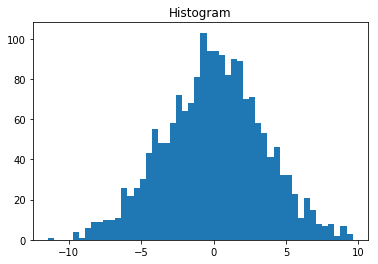

In [6]:
residuals.plot.hist(bins=50);